In [1]:
import scipy as sp
import numpy as np
#import pylab as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


#so, we have to completely rewrite the code, and basically do what he told us to do at the beginning, DISCRETIZE!!!

def FHNneuron(I,timespan,dt,point):
    #parameters
    #would be nice to explain what each param means
    a=0.7
    b=0.8
    c=3
    
    #these two params from scholarpedia, would like better justification
    R=1
    tauinv=0.08*3 #1/tau
    t=np.arange(0.0, timespan, dt)
    
    #lets add noise with some modulation by a constant 0<k<1;
    k1=0.1
    k2=0.1
    
    v=np.zeros(len(t))
    w=np.zeros(len(t))
    
    v[0]=point[0]
    w[0]=point[1]
    
    for i in range (len(t)-1):
        v[i+1]=v[i]+dt*(v[i]-(v[i]**3)/3 + w[i] - R*I)
        w[i+1]=w[i]+dt*(-(tauinv/c)*(v[i] - a + b*w[i]))
    
    return v,w

In [2]:
def FHNneuronNoisy(I,timespan,dt,point,k1,k2):
    #parameters
    #would be nice to explain what each param means
    a=0.7
    b=0.8
    c=3
    
    #these two params from scholarpedia, would like better justification
    R=1
    tauinv=0.08*3 #1/tau
    t=np.arange(0.0, timespan, dt)
    
    #lets add noise with some modulation by a constant k1,k2
    
    noise1=k1*np.sqrt(dt)*np.random.normal(0,1,len(t))
    noise2=k2*np.sqrt(dt)*np.random.normal(0,1,len(t))
    
    v=np.zeros(len(t))
    w=np.zeros(len(t))
    
    v[0]=point[0]
    w[0]=point[1]
    
    for i in range (len(t)-1):
        v[i+1]=v[i]+dt*(v[i]-(v[i]**3)/3 + w[i] - R*I)   + noise1[i]
        w[i+1]=w[i]+dt*(-(tauinv/c)*(v[i] - a + b*w[i]) ) + noise2[i]
    
    return v,w

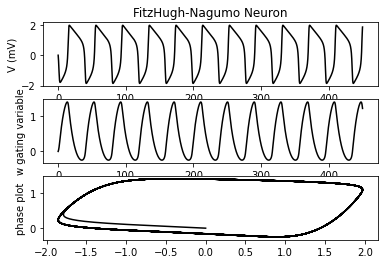

In [3]:
I=0.5;
tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)
neuron1=FHNneuron(I,tstop,dt,[0,0]);
v=neuron1[0];
w=neuron1[1];

plt.figure()

plt.subplot(3,1,1)
plt.title('FitzHugh-Nagumo Neuron')
plt.plot(t, v, 'k')
plt.ylabel('V (mV)')

plt.subplot(3,1,2)
plt.plot(t, w, 'k')
plt.ylabel('w gating variable')

plt.subplot(3,1,3)
plt.plot(v, w, 'k')
plt.ylabel('phase plot')

plt.show()    
    

(-0.5, 2.0)

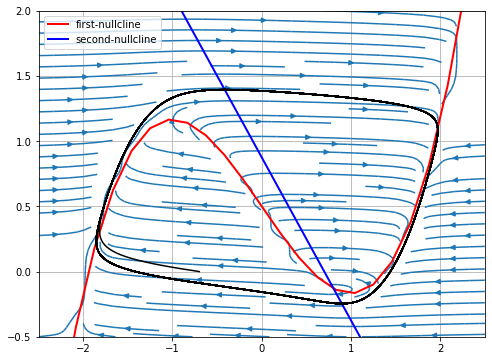

In [4]:
#for this, pick Iext
Iext=0.5;
tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);

a=0.7
b=0.8
c=3

def Syst(X,Iext): #without time
    a=0.7
    b=0.8
    c=3
    #these two params from scholarpedia, would like better justification
    R=1
    tauinv=0.08 #1/tau
    """
    Integrate

    |  :param X:
    |  :param t:
    |  :return: calculate membrane potential & activation variables
    """
        
    v, w = X
        
    dvdt = v - (v**3)/3 + w - R*Iext
    dwdt = -(tauinv/c)*(v - a + b*w)
        
    return dvdt, dwdt

def w1(v,Iext):
    return (-v + (v**3)/3 + Iext)

def w2(v,Iext):
    return -(v - a)/b

ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M

ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()
plt.xlim(-2.5,2.5)
plt.ylim(-0.5,2)

In [5]:
def find_roots(I): #This gives the equilibrium points, given I
    a=0.7
    b=0.8
    coeff=[1/3, 0, 1/b - 1, -a/b + I] #I think this gives the right equation...
    #Only keep real roots:
    roots = [np.real(r) for r in np.roots(coeff) if np.isreal(r)]
    # We store the position of the equilibrium. 
    return [[r, (-r + (r**3)/3 + I)] for r in roots]

In [6]:
def jacobian(point, I): #find jacobian by hand, put equilibrium points into here
    a=0.7
    b=0.8
    c=3
    tau=1/(0.08*3) #1/tau
    v=point[0]
    w=point[1]
    return np.array([[c*(-v**2 + 1) , c],
                       [-1/(c*tau), -b/(c*tau)]])

In [7]:
def stability(jacobian): #Put jacobian into here and it says what kind of point it is, (unchanged)
    eigv = np.linalg.eigvals(jacobian)
    
    if all(np.real(eigv)==0) and all(np.imag(eigv)!=0):
        nature = "Center" 
    elif np.real(eigv)[0]*np.real(eigv)[1]<0:
        nature = "Saddle"
    else: 
        stability = 'Unstable' if all(np.real(eigv)>0) else 'Stable'
        nature = stability + (' focus' if all(np.imag(eigv)!=0) else ' node')
    return nature

In [8]:
find_roots(0.5)[0]

[0.8048477470083345, -0.131059683760418]

In [9]:
jacobian(find_roots(0.5)[0],0.5)

array([[ 1.05666031,  3.        ],
       [-0.08      , -0.064     ]])

In [10]:
stability(jacobian(find_roots(0.5)[0],0.5))

'Unstable node'

In [11]:
#IT WORKS!!!!!, so now, can we add these to a graph???

Unstable node
[0.8048477470083345, -0.131059683760418]


(-0.5, 2.0)

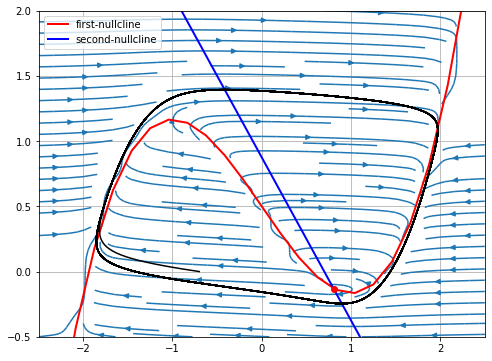

In [12]:
#for this, pick Iext
Iext=0.5;
tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);


a=0.7
b=0.8
c=3

def Syst(X,Iext): #without time
    a=0.7
    b=0.8
    c=3
    #these two params from scholarpedia, would like better justification
    R=1
    tauinv=0.08 #1/tau
    """
    Integrate

    |  :param X:
    |  :param t:
    |  :return: calculate membrane potential & activation variables
    """
        
    v, w = X
        
    dvdt = v - (v**3)/3 + w - R*Iext
    dwdt = -(tauinv/c)*(v - a + b*w)
        
    return dvdt, dwdt

def w1(v,Iext):
    return (-v + (v**3)/3 + Iext)

def w2(v,Iext):
    return -(v - a)/b

ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')


tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)
neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"ro")

ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()
plt.xlim(-2.5,2.5)
plt.ylim(-0.5,2)

Unstable node
[0.8048477470083345, -0.131059683760418]


(-0.5, 2.0)

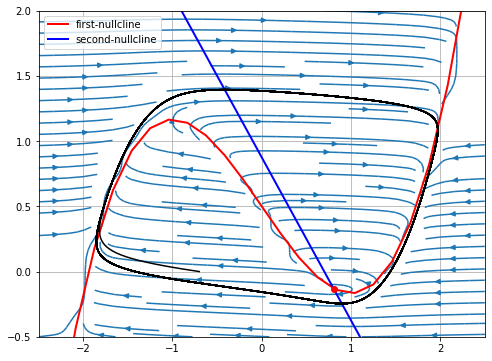

In [13]:
#for this, pick Iext
Iext=0.5;
t=np.arange(0.0, 450.0, 0.01);

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)
neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"ro")


plt.xlim(-2.5,2.5)
plt.ylim(-0.5,2)

Unstable node
[0.40886583694341133, 0.3639177038207357]


(-0.5, 2.0)

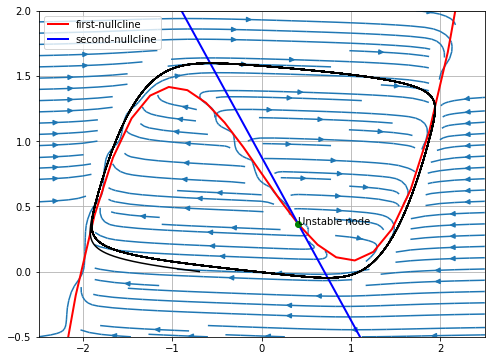

In [14]:
#for this, pick Iext
Iext=0.75;
t=np.arange(0.0, 450.0, 0.01);

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);


ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)
neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.5,2.5)
plt.ylim(-0.5,2)

Text(0, 0.5, 'V')

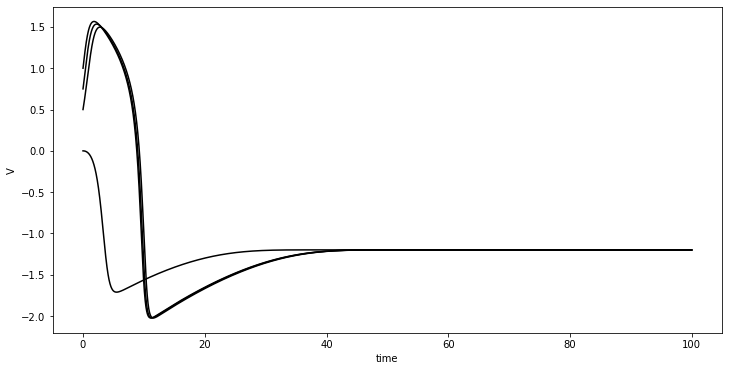

In [15]:
fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

Iext=0;
tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

points=[[0,0],[-0.5,0],[-0.75,0],[-1,0]]

for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=-neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('time')
plt.ylabel('V')

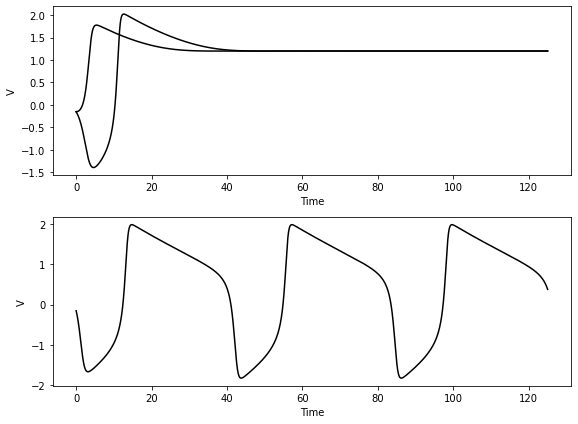

In [40]:
fig,axs=plt.subplots(2,1,figsize=(8,6))

Iext=0;
tstop=125;
dt=0.01
t=np.arange(0.0, tstop, dt)

points=[[-0.15,0],[-0.15,0.15]]

for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    axs[0].plot(t,va,'k-')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('V')


Iext=0.4;
neuron2=FHNneuron(Iext,tstop,dt,point)
va2=neuron2[0];
wa2=neuron2[1];
axs[1].plot(t,va2,'k-')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('V')

plt.tight_layout()


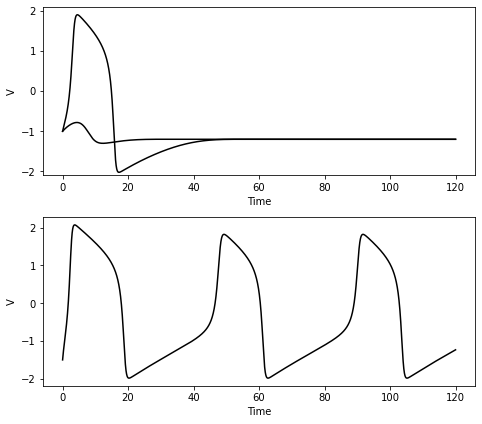

In [74]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6))

Iext=0;
tstop=120;
dt=0.01
t=np.arange(0.0, tstop, dt)

points=[[1,-1],[1,-0.76]]

for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=-neuron[0];
    wa=neuron[1];
    axs[0].plot(t,va,'k-')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('v')
axs[0].set_ylim(-2.1,2.1)


Iext=0.4;
neuron2=FHNneuron(Iext,tstop,dt,[1.5,-1])
va2=-neuron2[0];
wa2=neuron2[1];
axs[1].plot(t,va2,'k-')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('v')
plt.tight_layout()


0.25
0.5
0.75


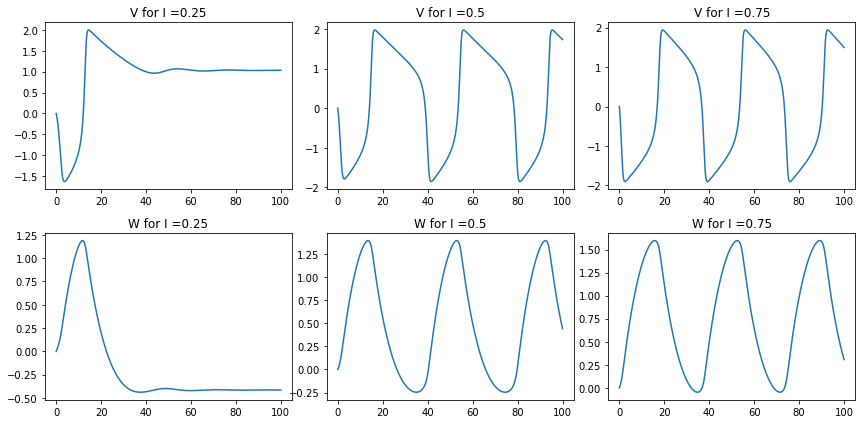

In [18]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];

currents = [0.25, 0.5, 0.75];

fig,axs=plt.subplots(2,len(currents),figsize=(12,6)) #,figsize=(12,6)

for i in range(len(currents)):
    I=currents[i]
    neuron=FHNneuron(I,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,va)
    axs[0,i].set_title("V for I ="+str(I))
    axs[1,i].plot(t,wa)
    axs[1,i].set_title("W for I ="+str(I))
    print(I)
    
plt.tight_layout()


Stable node
[1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'V')

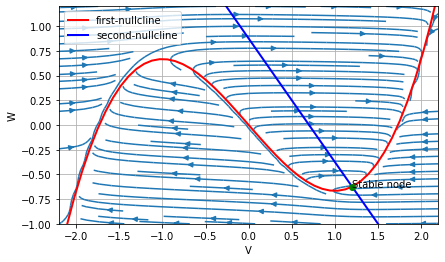

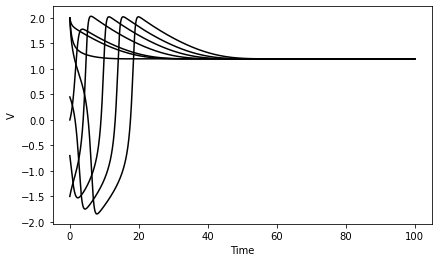

In [38]:
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(6.8,4))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')

fig3 = plt.figure(figsize=(6.8,4))
ax5 = fig3.add_subplot(1,1,1)

for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('Time')
plt.ylabel('V')



Stable node
[1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'V')

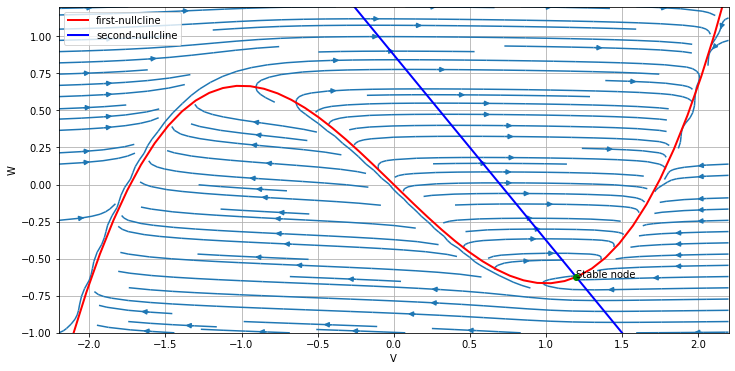

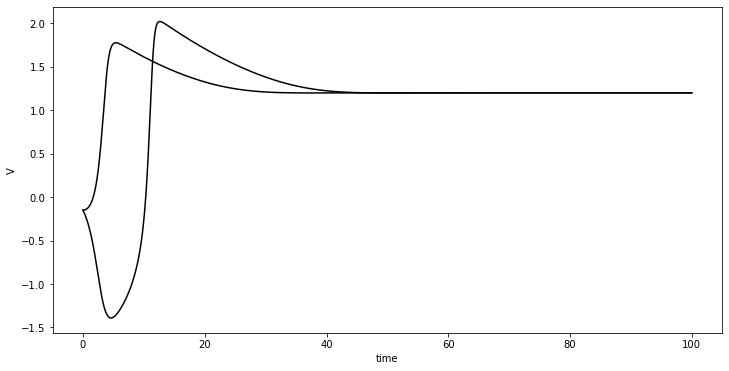

In [20]:
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')

fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('time')
plt.ylabel('V')



Stable node
[1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'v')

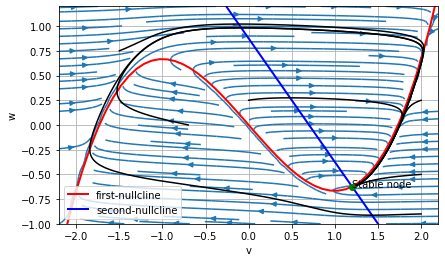

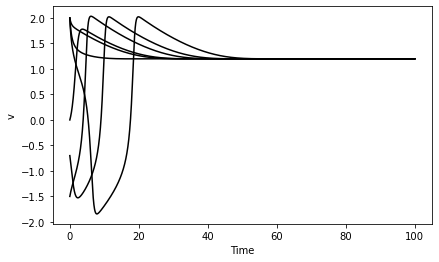

In [39]:
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(6.8,4))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

points=[[-0.7,0],[0,0.25],[2,-0.9],[2,-0.5],[-1.5,0.75],[2,0.25]]
for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')

    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('v')
plt.ylabel('w')

fig3 = plt.figure(figsize=(6.8,4))
ax5 = fig3.add_subplot(1,1,1)

for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('Time')
plt.ylabel('v')



Stable node
[1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'V')

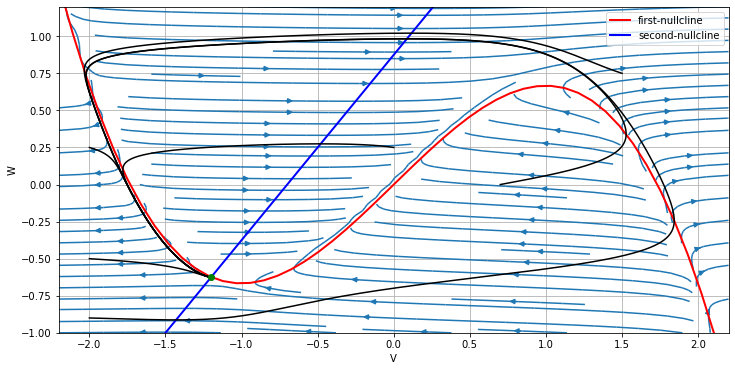

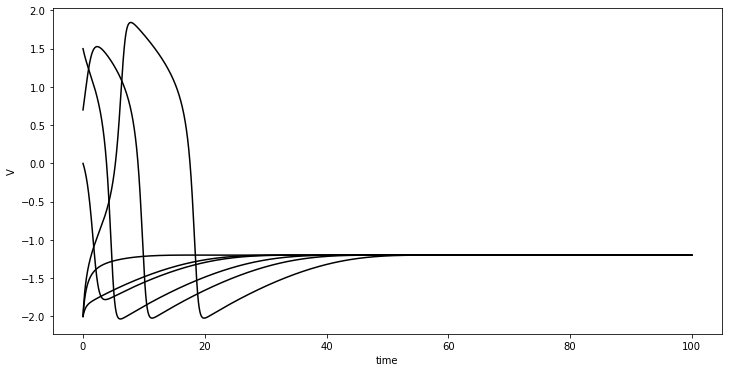

In [22]:
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(-v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(-v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(-v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

points=[[-0.7,0],[0,0.25],[2,-0.9],[2,-0.5],[-1.5,0.75],[2,0.25]]
for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=-neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')

    
ax4.streamplot(-V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(-root[0],root[1],"go")
    #plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')

fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=-neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('time')
plt.ylabel('V')



0.25
0.5
0.75


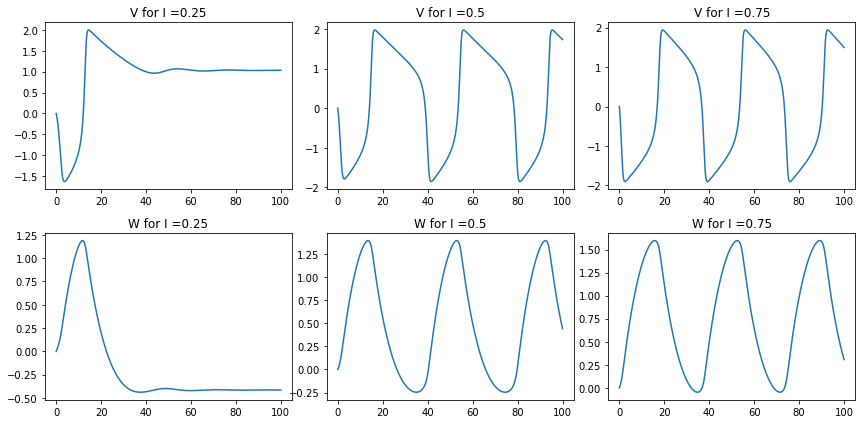

In [23]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];

currents = [0.25, 0.5, 0.75];

fig,axs=plt.subplots(2,len(currents),figsize=(12,6)) #,figsize=(12,6)

for i in range(len(currents)):
    I=currents[i]
    neuron=FHNneuron(I,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,va)
    axs[0,i].set_title("V for I ="+str(I))
    axs[1,i].plot(t,wa)
    axs[1,i].set_title("W for I ="+str(I))
    print(I)
    
plt.tight_layout()


Stable focus
[1.0324802239110462, -0.41560027988880766]
Unstable node
[0.8048477470083345, -0.131059683760418]
Unstable node
[0.40886583694341133, 0.3639177038207357]


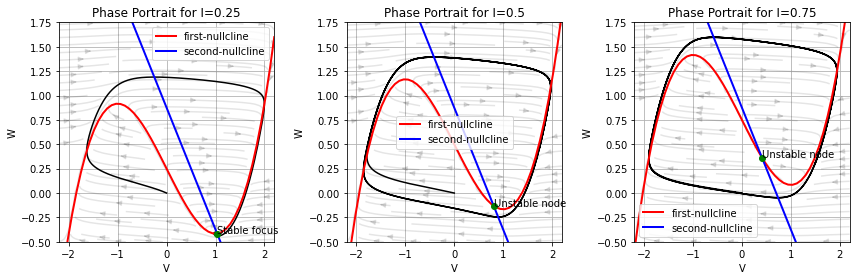

In [24]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];

currents = [0.25, 0.5, 0.75];

fig,axs=plt.subplots(1,len(currents),figsize=(12,4)) #,figsize=(12,6)
for i in range(len(currents)):
    I=currents[i]
    neuron=FHNneuron(I,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];

    axs[i].plot(va,wa,'k-')
    #for this, pick Iext

    #fig2 = plt.figure(figsize=(12,6))
    #ax4 = fig2.add_subplot(1,1,1)

    v=np.linspace(-2.2,2.2,50);
    w=np.linspace(-0.5,1.75,50);



    axs[i].plot(v,w1(v,I),'r-', lw=2, label='first-nullcline')
    axs[i].plot(v,w2(v,I),'b-', lw=2, label='second-nullcline')
    

    V1, W1 = np.meshgrid(v, w)
    DV1, DW1 = Syst([V1, W1],I)
    M = (np.hypot(DV1, DW1))
    M[ M == 0] = 1.
    DV1 /= M
    DW1 /= M


    axs[i].streamplot(V1, W1, DV1, DW1,color=(0,0,0,.1))
    axs[i].legend()
    axs[i].grid()

    roots=find_roots(I);
    for root in roots:

        label=stability(jacobian(root,I))
        print(label)
        print(root)
        axs[i].plot(root[0],root[1],"go")
        axs[i].annotate(label,root)

    axs[i].set_xlim(-2.2,2.2)
    axs[i].set_ylim(-0.5,1.75)
    axs[i].set_xlabel('V')
    axs[i].set_ylabel('W')
    axs[i].set_title("Phase Portrait for I="+str(I))
plt.tight_layout()


Stable node
[1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'V')

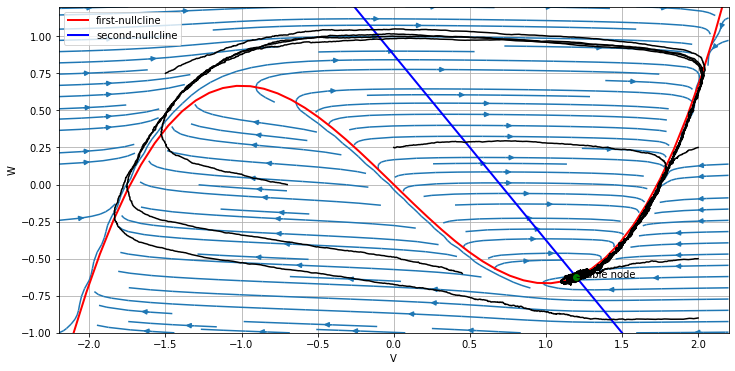

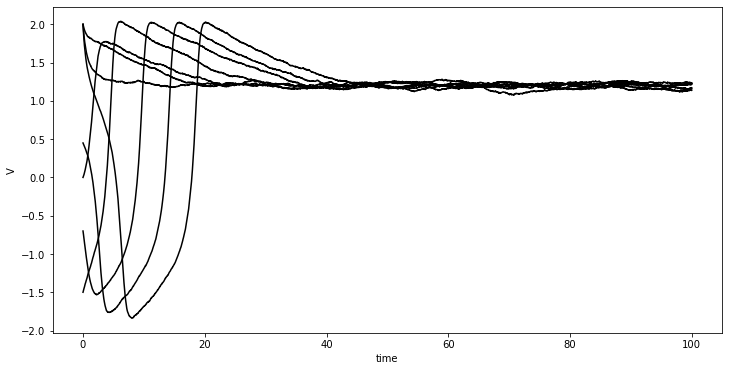

In [25]:
#so now, same general thing for noise levels
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

points=[[-0.7,0],[0,0.25],[2,-0.9],[2,-0.5],[-1.5,0.75],[2,0.25],[0.45,-0.6]]
for point in points:
    neuron=FHNneuronNoisy(Iext,tstop,dt,point,0.01,0.01);
    va=neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')

    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')

fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

for point in points:
    neuron=FHNneuronNoisy(Iext,tstop,dt,point,0.01,0.01);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('time')
plt.ylabel('V')



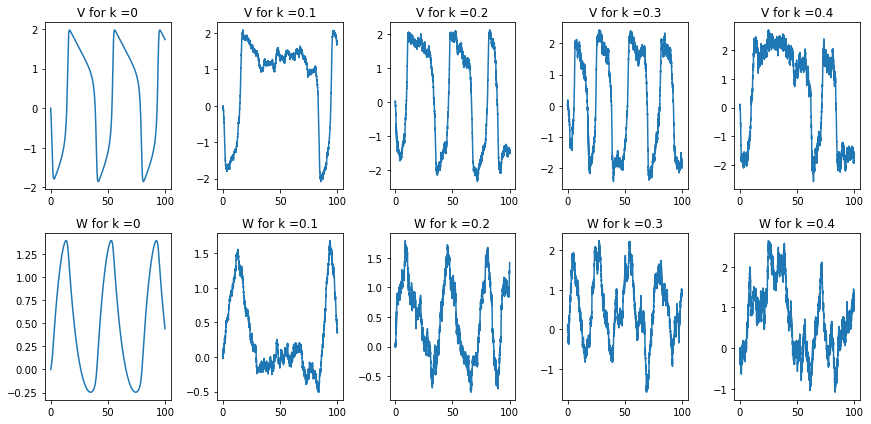

In [26]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];
I=0.5

noises = [0, 0.1, 0.2, 0.3, 0.4];

fig,axs=plt.subplots(2,len(noises),figsize=(12,6)) #,figsize=(12,6)

for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,va)
    axs[0,i].set_title("V for k ="+str(k1))
    axs[1,i].plot(t,wa)
    axs[1,i].set_title("W for k ="+str(k1))
    
plt.tight_layout()


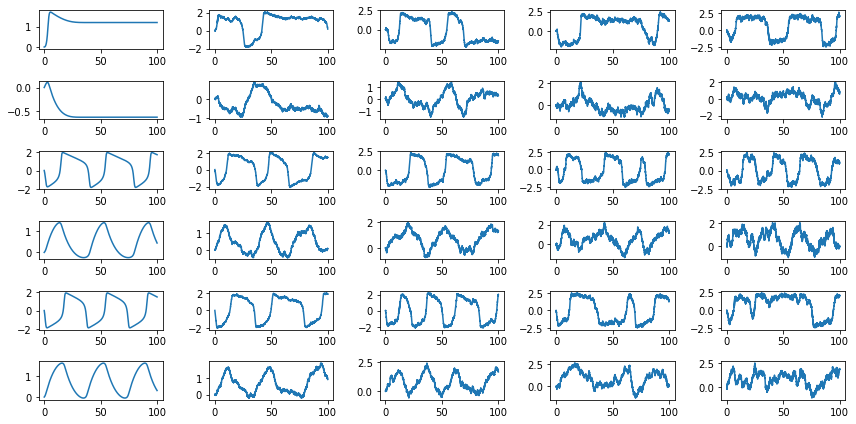

In [27]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];
#I=0.5

noises = [0, 0.1, 0.2, 0.3, 0.4];
currents = [0,0.5,0.75]

fig,axs=plt.subplots(2*len(currents),len(noises),figsize=(12,6)) #,figsize=(12,6)
for j in range(len(currents)):
    for i in range(len(noises)):
        k1=noises[i]
        k2=k1
        I=currents[j]
        neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
        va=neuron[0];
        wa=neuron[1];
        axs[2*j,i].plot(t,va)
        #axs[2*j,i].set_title("V for k ="+str(k1)+" I="+str(I))
        axs[2*j+1,i].plot(t,wa)
        #axs[2*j+1,i].set_title("W for k ="+str(k1)+" I="+str(I))
    
plt.tight_layout()


Unstable node
[0.8048477470083345, -0.131059683760418]


(-0.5, 2.0)

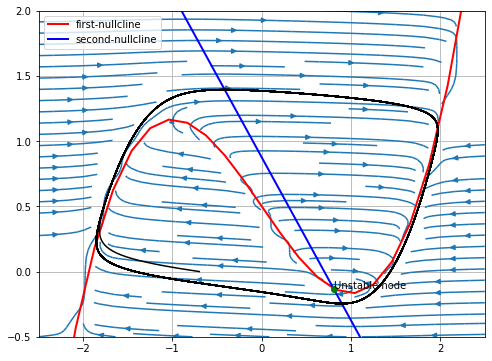

In [28]:
#for this, pick Iext
Iext=0.5;
t=np.arange(0.0, 450.0, 0.01);

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);


ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)
neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.5,2.5)
plt.ylim(-0.5,2)

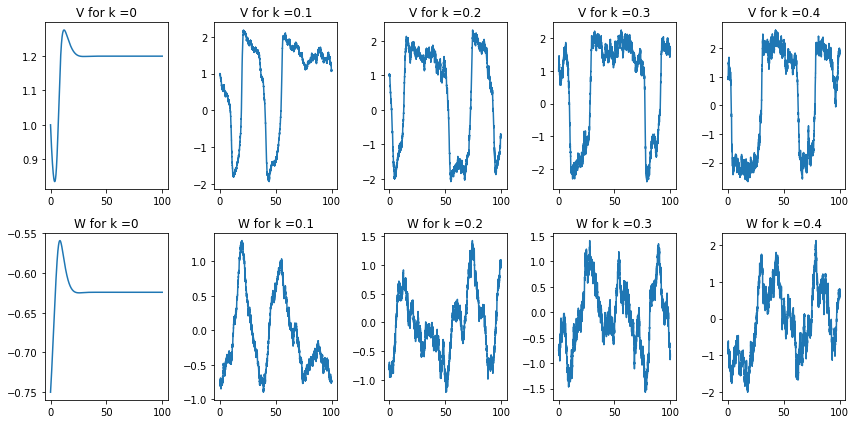

In [29]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[1,-0.75];
I=0

noises = [0, 0.1, 0.2, 0.3, 0.4];

fig,axs=plt.subplots(2,len(noises),figsize=(12,6)) #,figsize=(12,6)

for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,va)
    axs[0,i].set_title("V for k ="+str(k1))
    axs[1,i].plot(t,wa)
    axs[1,i].set_title("W for k ="+str(k1))
    
plt.tight_layout()


Stable node
[1.1994080352440346, -0.6242600440550439]


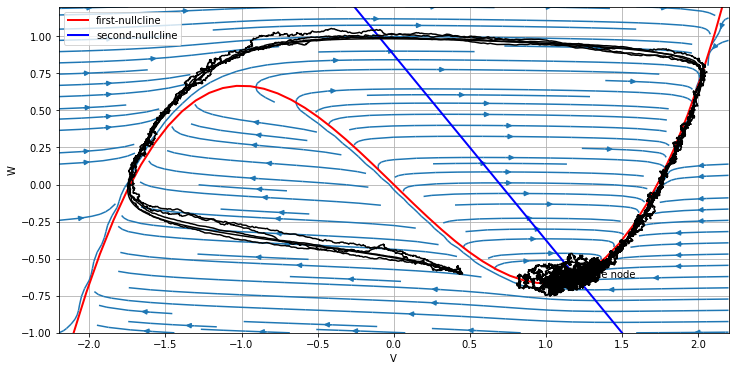

In [30]:
#so now, same general thing for noise levels
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)



    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')







tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0.45,-0.6];
I=0

noises = [0, 0.01, 0.02, 0.03, 0.04];


for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')
    















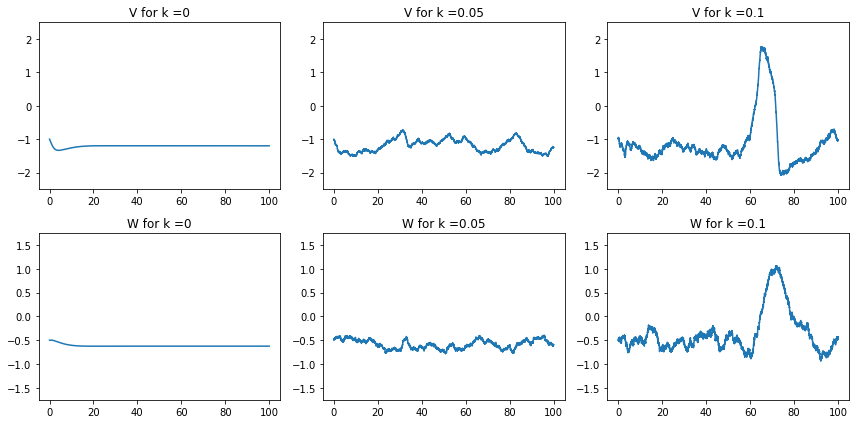

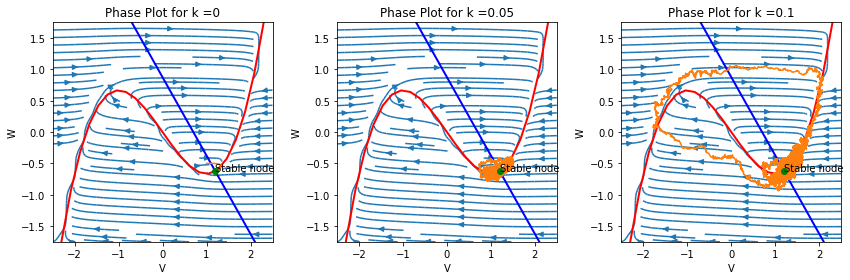

In [31]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[1,-0.5];
I=0

noises = [0, 0.05, 0.1];










fig1,axs1=plt.subplots(2,len(noises),figsize=(12,6)) #,figsize=(12,6)
fig2,axs2=plt.subplots(1,len(noises),figsize=(12,4)) #,figsize=(12,6)


v=np.linspace(-2.5,2.5,25);
w=np.linspace(-1.75,1.75,25);

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],I)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M




for i in range(len(noises)):
    
    

    
    axs2[i].streamplot(V1, W1, DV1, DW1)
    axs2[i].plot(v,w1(v,I),'r-', lw=2, label='first-nullcline')
    axs2[i].plot(v,w2(v,I),'b-', lw=2, label='second-nullcline')
    
    
    
    
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    
    axs1[0,i].plot(t,-va)
    axs1[0,i].set_title("V for k ="+str(k1))
    axs1[1,i].plot(t,wa)
    axs1[1,i].set_title("W for k ="+str(k1))    
    axs1[0,i].set_ylim(-2.5,2.5)
    axs1[1,i].set_ylim(-1.75,1.75)
    
    axs2[i].plot(va,wa)
    axs2[i].set_title("Phase Plot for k ="+str(k1))
    
    
    
    
    
    roots=find_roots(I);
    for root in roots:
        label=stability(jacobian(root,I))
        #print(label)
        #print(root)
        axs2[i].plot(root[0],root[1],"go")
        axs2[i].annotate(label,root)
    
    
    
    axs2[i].set_xlim(-2.5,2.5)
    axs2[i].set_ylim(-1.75,1.75)
    axs2[i].set_xlabel('V')
    axs2[i].set_ylabel('W')
    

    
    
    
    
fig1.tight_layout()
fig2.tight_layout()




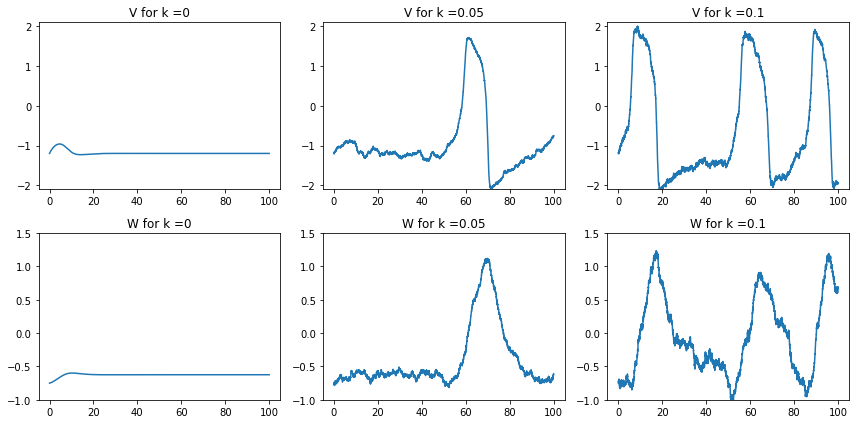

In [32]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[1.2,-0.75];
I=0

noises = [0, 0.05, 0.1];

fig,axs=plt.subplots(2,len(noises),figsize=(12,6)) #,figsize=(12,6)

for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,-va)
    axs[0,i].set_title("V for k ="+str(k1))
    axs[0,i].set_ylim(-2.1,2.1)
    axs[1,i].plot(t,wa)
    axs[1,i].set_ylim(-1,1.5)
    axs[1,i].set_title("W for k ="+str(k1))
    
plt.tight_layout()


Stable node
[1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'V')

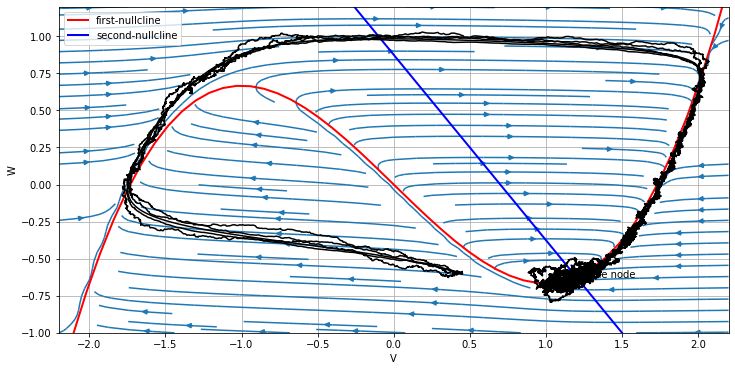

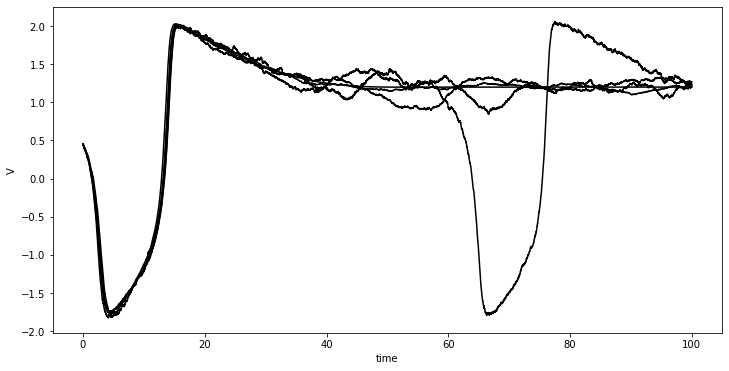

In [33]:
#so now, same general thing for noise levels
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)



    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')







tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0.45,-0.6];
I=0

noises = [0, 0.01, 0.02, 0.03, 0.04];


for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')
    











plt.xlabel('V')
plt.ylabel('W')


fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('time')
plt.ylabel('V')



Stable node
[1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'V')

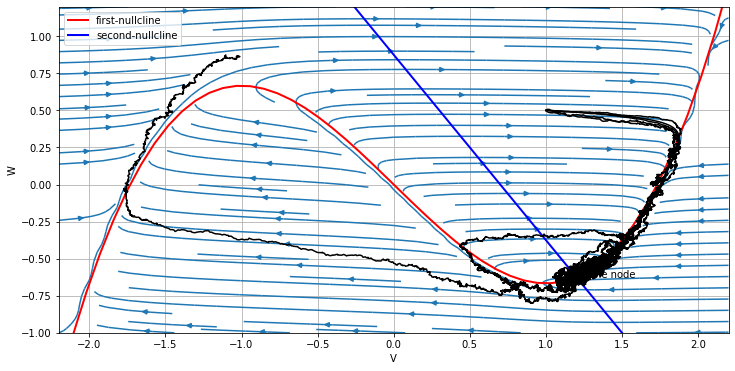

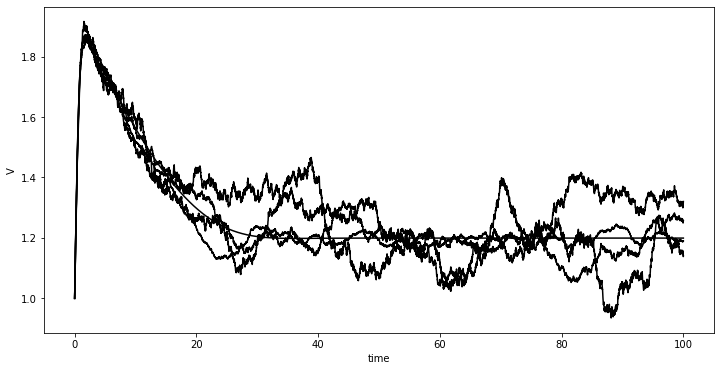

In [34]:
#so now, same general thing for noise levels
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)



    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')







tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[1,0.5];
I=0

noises = [0, 0.01, 0.02, 0.03, 0.04];


for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')
    











plt.xlabel('V')
plt.ylabel('W')


fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('time')
plt.ylabel('V')

